In [1]:
import numpy as np
import scipy.sparse as sp
import re
import json
from itertools import combinations
import time

from scipy.sparse import linalg as spl
from collections import defaultdict
from IPython.display import Markdown, display

import matplotlib.pyplot as plt
import time as t

%matplotlib inline

In [2]:
words = np.load('top_25k_words.npy')
bow_subset = sp.load_npz('bow_subset.npz')
N = bow_subset.shape[0]

with open('reviews_subset.json' , 'r') as f:
    reviews = json.load(f)

In [3]:
def cosine_distance(X, i, j):

    i_norm = np.math.sqrt(np.dot(X[:,i], X[:,i]))
    j_norm = np.math.sqrt(np.dot(X[:,j], X[:,j]))
    
    ij_dot = X[:,i].dot(X[:,j].T)
    
    return 1-ij_dot/(i_norm*j_norm)

In [4]:
def LSH(X, b=8, r=32, d=0.3):
    
    np.random.seed(158)
    n_candidates = 0
    duplicates = set()
    
    def compare(a):
        hash1 = hash(tuple(a))
        return (hash1)
    
    band=0
    
    #generating random hyperplane and creating matrix of -1,1
    V = []
    V = np.array(V)
    V = np.random.normal(size = [b*r,bow_subset.shape[1]])
    random_proj = bow_subset.dot(V.T)
    
    random_proj[random_proj<0] = -1
    random_proj[random_proj>=0] = 1
    
    #generating hash table with bucket name = band number_hash value
    random_proj1 = random_proj.T    
    hash_table=dict()
    
    for k in range(0,b*r,r):
        band +=1
        for i in range(random_proj1.shape[1]):
            hash1 = compare(random_proj1[k:k+r,i])
            hash2 = "band_"+str(band)+"_"+str(hash1)
            if hash2 not in hash_table:
                hash_table[hash2]=[i]
            else:
                hash_table[hash2].append(i)
    result1 = {}           
    
    #{k:v for (k,v) in hash_table.items() if len(v) > 1}
    for (k,v) in hash_table.items():
        if len(v) > 1:
            n_candidates +=(len(list(combinations(v, 2))))
            result1[k]=v
    
    random_proj2 = random_proj1
    random_proj2[random_proj2 < 0] = 0
    
    
    #exact duplicates with cosine distance
    result = {}
    for key,value in result1.items():
        if value not in result.values():
            result[key] = value
    X = X.T    
    for (k,values) in result.items():
        ab = (list(combinations(values, 2)))
        for x in ab:
            dist1 = cosine_distance(random_proj2,x[0],x[1])
            if dist1<d:
                duplicates.add((x[0],x[1],dist1))
    
    return duplicates, n_candidates

In [5]:
duplicates, n_candidates = LSH(bow_subset, b=6, r=28, d=0.2)

In [6]:
 print('We detected {} candidates.'.format(n_candidates))

We detected 861 candidates.


In [7]:
duplicates

{(1780, 58112, 0.1702443178597306),
 (1809, 13244, 0.0),
 (6600, 93310, 0.0),
 (17779, 72702, 0.0),
 (29327, 67068, 0.18801049081622256),
 (32066, 71726, 0.0),
 (35163, 82597, -2.2204460492503131e-16),
 (36118, 46204, 0.19446164037896352),
 (42795, 95179, -2.2204460492503131e-16),
 (47940, 65607, 2.2204460492503131e-16),
 (64525, 70002, 0.15394031329695645)}

In [8]:
similar_review_pairs = []
for ix1, ix2, sim in duplicates:
    rev1 = reviews[ix1]
    rev2 = reviews[ix2]
    similar_review_pairs.append((rev1, rev2, sim))

In [9]:
pattern = re.compile('(\S+|\n)')
pattern_punctuation = re.compile('^\W+|\W+$')

def highlight_vocabulary(text, vocabulary):
    split = re.findall(r"[\w']+", text)
    in_vocabulary = [pattern.sub(lambda m: pattern_punctuation.sub('', m.group()), str.lower(x)) in words for x in split]
    highlighted_words = ["**{}**".format(x) if in_vocabulary[ix] else x for ix,x in enumerate(split) ]
    highlighted_text = " ".join(highlighted_words)
    return highlighted_text

def printmd(string):
    display(Markdown(string))

In [10]:
for r1, r2, sim in similar_review_pairs:
    if not np.isclose(sim, 0.0):
        printmd(highlight_vocabulary(r1['text'], words))
        print("")
        print("vs.")
        print("")
        printmd(highlight_vocabulary(r2['text'], words))
        print("===")
        print("Same business: {}".format(r1['business_id'] == r2['business_id']))
        print("Same user: {}".format(r1['user_id'] == r2['user_id']))
        print("Cosine distance {:.4f}".format(sim))
        print("")    
        print("#######")
        print("")

**Finally** The **Habit** is in **Las** **Vegas** **Worth** the **wait** and **yes** the **hype** is **real** about this **place** I **love** the **burgers** and the **onion** **rings** **Nothing** here is **greasy** and the **quality** of **food** **shows** as **well** I **usually** **get** the **double** **char** which is **similar** to a **double** **double** at in **n** out The **food** is **made** to **order** and the **staff** is on **top** of **things** **Even** **though** this is a **soft** **opening** **today** **things** **seem** very **organized** **Good** **food** and **great** **service** If your **looking** for a **burger** **place** that **serves** **good** **food** this is your **place** I **also** **love** the **variety** **Salads** **tri** **tip** **chicken** and **much** more More **locations** are **coming** to **Las** **Vegas** The **next** **location** will be **Blue** **Diamond** and **Decatur** **Opening** **sometime** at the **beginning** of 2016 **10** **15** **locations** in the **future**


vs.



We **heard** about this **place** **thanks** to **Triple** D on **Food** **Network** and we **took** the **bus** to **get** to it We **shared** the **crab** and **artichoke** **dip** to **start** then I had **shrimp** **po'boy** **followed** by a **chocolate** **dessert** Their **specialty** **dessert** **seems** to be **sweet** **potato** **pecan** **pie** **Great** **food** **good** **wine** and **service** This **Cajun** **creole** **place** is **really** **good** I **know** a **lot** of **visitors** to **Vegas** **never** **venture** **beyond** the **strip** but you're **missing** out on a **great** **spot** here if you're into **Cajun** **food** It was **pretty** **busy** the **night** we **went** and it was **definitely** **worth** the **wait**

===
Same business: False
Same user: False
Cosine distance 0.1880

#######



**TERRIBLE** **SERVICE** **Waited** for **10** **minutes** for **someone** to **even** **come** to the **table** When we **left** **people** who were **seated** after **us** had been **served**


vs.



We didn't **even** **get** to **try** the **food** We were **seated** and **sat** there for **30** **minutes** to be **waited** on We **watched** **others** **around** **us** being **waited** on **even** **people** **seated** AFTER we were but no **one** **even** **stopped** to **ask** if we had been **helped** After **30** **minutes** of that we **got** up and **left** No **15** **sundae** is **worth** **crappy** **service**

===
Same business: False
Same user: False
Cosine distance 0.1945

#######



**Good** **Service** **Good** **food**


vs.



**Service** is **good** very **friendly** and **good** **food** who **could** **want** more nagar it was very **good**

===
Same business: False
Same user: False
Cosine distance 0.1539

#######



very **good** **food** **good** **service** the **part** we didn't **like** is being **reminded** to **include** the **tip** when **paying** the **bill**


vs.



**Food** is veryyyy **good** **Customer** **service** is not so **good** But it's **worth** if for the **food**

===
Same business: False
Same user: False
Cosine distance 0.1702

#######



In [11]:
# naively compute the duplicates using a double for loop
def naive_duplicates(X, d = 0.2):
    
    X = X.toarray()
    N = X.shape[0]
    duplicates = set()
    for i in range(0, N):
        for j in range(i+1, N):
            d_ij = cosine_distance(X.T, j, i)
            if d_ij < d and i != j:
                duplicates.add((i, j, d_ij))
    return duplicates

In [12]:
 def runtime_comparison():
    
    trace = []
    trace.append([0, 0, 0])
    for n in np.arange(250, 2501, 250):
        print('Running comparison for {} reviews.'.format(n))
        
        startLSH = t.clock()
        LSH(bow_subset[0:n, :], b=5, r=25, d=0.2)
        endLSH = t.clock()
        LSHtime = endLSH-startLSH
        
        startNaive = t.clock()
        naive_duplicates(bow_subset[0:n, :], d = 0.2)
        endNaive = t.clock()
        naiveTime = endNaive-startNaive
        
        trace.append([n, LSHtime, naiveTime])
        
    return trace

In [13]:
trace = runtime_comparison()

Running comparison for 250 reviews.
Running comparison for 500 reviews.
Running comparison for 750 reviews.
Running comparison for 1000 reviews.
Running comparison for 1250 reviews.
Running comparison for 1500 reviews.
Running comparison for 1750 reviews.
Running comparison for 2000 reviews.
Running comparison for 2250 reviews.
Running comparison for 2500 reviews.


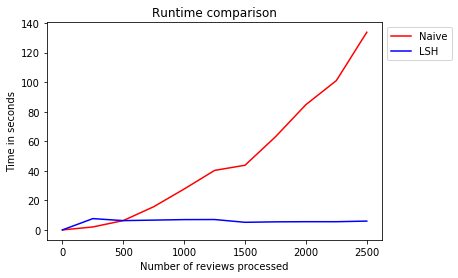

In [14]:
trace = np.array(trace)
num_reviews = trace[:, 0]
lshtime = trace[:, 1]
naivetime = trace[:, 2]

naive = plt.plot(num_reviews, naivetime, 'r')
LSH = plt.plot(num_reviews, lshtime, 'b')
plt.legend(['Naive', 'LSH'], bbox_to_anchor=(1, 1))

plt.xlabel('Number of reviews processed')
plt.ylabel('Time in seconds')
plt.title('Runtime comparison')
plt.show()